In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.dirname('./ml/tio_dataset'))
sys.path.append(os.path.dirname('./ml/models'))
sys.path.append(os.path.dirname('./ml/metrics'))
sys.path.append(os.path.dirname('./ml/utils'))
sys.path.append(os.path.dirname('./ml/models/activates'))
sys.path.append(os.path.dirname('./ml/models.building_blocks'))

In [3]:
from models.ResUnet import ResUNet, ResUNet2d
from models.unet_deepsup import Unet_MSS
from ml.models.unet3d import U_Net
from models.CycleGAN import VanGan
from building_blocks import VG_discriminator, VG_discriminator2d

from tio_dataset import TioDataset
from VG_controller import VG_Controller

from utils import save_model, get_total_params, load_pretrainned

In [4]:
train_settings  = {
    "patch_shape" : (64, 64, 64),
    "patches_per_volume" : 16,
    "patches_queue_length" : 2048,
    "batch_size" : 12,
    "num_workers": 4,
    "sampler": "weighted" #"uniform",#
}

test_settings  = {
    "patch_shape" : (256, 256, 64),
    "overlap_shape" : (32, 32, 16),
    "batch_size" : 1,
    "num_workers": 4,
}

data_dir = "/home/msst/Documents/medtech/data/HessData_IXI"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=None,
                 test_settings=test_settings)

In [5]:
#for patches_batch in tqdm(train_dataloader):

In [6]:
import torch.nn as nn
modules_for_3d = {
    'gen_IS': U_Net(channels=8, act=nn.Sigmoid(), use_input_noise=False),
    "gen_SI": U_Net(channels=8, act=nn.Identity(), use_input_noise=True),
    # 'gen_IS': Unet_MSS(channels_coef=16, minimax_out=False),
    # #'gen_IS': ResUNet(channels_coef=12, use_input_noise=True, use_decoder_noise=True,
    # #                  out_act=nn.Identity(), minimax_out=False),
    # 'gen_SI': ResUNet(channels_coef=8, use_input_noise=True, use_decoder_noise=True,
    #                   out_act=nn.Identity(), minimax_out=False),
    
    'disc_I': VG_discriminator(channels_coef=8, use_input_noise=True, use_layer_noise=True),
    'disc_S': VG_discriminator(channels_coef=8, use_input_noise=True, use_layer_noise=True),
}

model = VanGan(modules_for_3d)
print("model params number:", get_total_params(model))

model params number: 4634382


In [7]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torchio as tio

from metrics import (DiscriminatorLoss, GeneratorLoss,
                     SSIM3D, soft_dice_cldice, CycleLoss)

from metrics import (DICE_Metric, JAC_Metric, SN_Metric, SP_Metric)

controller_config = {
          "device": "cuda",
          "otimizers_settings":{ #lr=0.002
            "gen_IS_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.9)),
            "gen_SI_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.9)),
            "disc_I_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.5, 0.9)),
            "disc_S_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.5, 0.9)),
            "sheduler_fn": None,#lambda optimizer: ExponentialLR(optimizer, 0.95)
            },
          "model": model,
          "losses":{
            "I_cycle_loss_fn": nn.L1Loss(), #CycleLoss("mae"),
            "S_cycle_loss_fn": nn.MSELoss(), #CycleLoss("mse"), #
            "reconstruction_loss_fn": SSIM3D(), #CycleLoss("ssim"), #SSIM3D(),
            "segmentation_loss_fn": CycleLoss("explog"), # CycleLoss("cldice"), #CycleLoss("explog"), #
            "discriminator_loss_fn": DiscriminatorLoss(),
            "generator_loss_fn": GeneratorLoss(),
            "cycle_lambda" : 5,#3, 
            "identity_lambda" : 10,#10,
            "reg_lambda": 10,  
            },
          "metrics": {
              "dice" : DICE_Metric(),
              "jac" : JAC_Metric(),
              "sen" : SN_Metric(),
              "spec" : SP_Metric()
              },
          "with_supervised": 0,
          }
vg_controller = VG_Controller(controller_config)

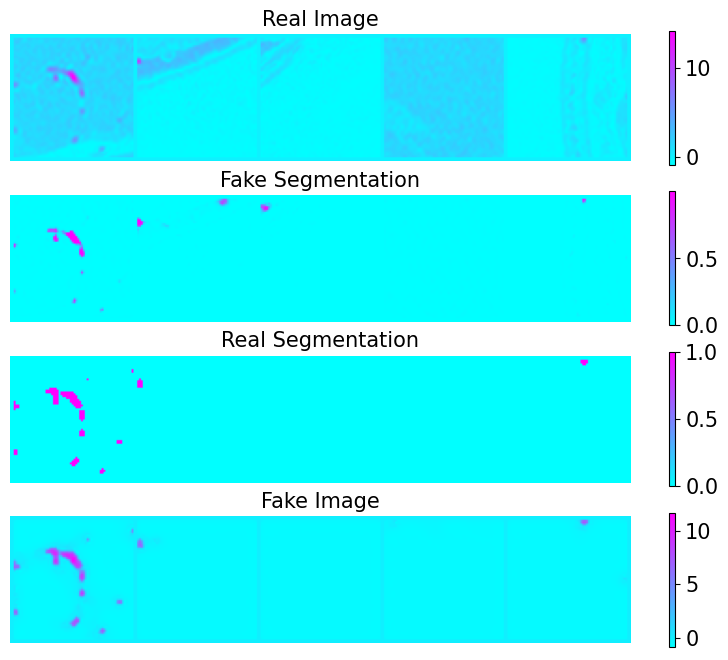

{'gen_IS_loss': 0.1927, 'gen_SI_loss': 0.0004, 'disc_I_loss': 0.0025, 'disc_S_loss': 0.2305, 'segmentation_loss': 0.0031, 'reconstruction_loss': 0.053, 'reg_loss': 0.0087}


VanGan(
  (gen_IS): U_Net(
    (input_noise): Identity()
    (noise_e2): Identity()
    (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv1): conv_block(
      (conv): Sequential(
        (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (Conv2): conv_block(
      (conv): Sequential(
        (0): Con

In [8]:
#vg_controller.set_initial_weights()
vg_controller.fit(dataset, 250)

In [9]:
model_name='GAN_TEST_8'#"VANGAN_ssim_unsupervised_25_0_1_z"
#save_model(model, '/home/msst/save_folder/saved_models', model_name)

In [10]:
load_pretrainned(model, f'/home/msst/save_folder/saved_models/{model_name}')

In [11]:
data_dir = "/home/msst/save_folder/seg_data/" + model_name
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
vg_controller.predict(dataset.test_dataloader, data_dir)

  0%|                                                     | 0/4 [00:00<?, ?it/s]

tensor(83084.6484)


 25%|███████████▎                                 | 1/4 [00:04<00:13,  4.34s/it]

tensor(73283.4141)


 50%|██████████████████████▌                      | 2/4 [00:08<00:08,  4.34s/it]

tensor(83581.7422)


 75%|█████████████████████████████████▊           | 3/4 [00:13<00:04,  4.39s/it]

tensor(75038.0234)


100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.40s/it]


[{'sample': 'IXI077_0',
  'dice': tensor([0.0083]),
  'jac': tensor([0.0042]),
  'sen': tensor([1.]),
  'spec': tensor([0.9980])},
 {'sample': 'IXI131_0',
  'dice': tensor([0.0010]),
  'jac': tensor([0.0005]),
  'sen': tensor([1.]),
  'spec': tensor([0.9974])},
 {'sample': 'IXI077_1',
  'dice': tensor([0.0103]),
  'jac': tensor([0.0052]),
  'sen': tensor([1.]),
  'spec': tensor([0.9981])},
 {'sample': 'IXI131_1',
  'dice': tensor([0.0012]),
  'jac': tensor([0.0006]),
  'sen': tensor([1.]),
  'spec': tensor([0.9974])}]